In [1]:
import numpy as np 
import pandas as pd 
import pickle

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
sys.path.append('..')

from utils.viz import viz 
from utils.model import *  
from utils.fig_fn import *
viz.get_style()

In [2]:
dpi = 300

## Model parameters

In [4]:
def print_params(data_set, models, method):
    for m in models: 
        df = get_fit_param(data_set, m, method=method)
        df['model'] = m
        p_names = df.columns[:-2]
        print(f'{m}:')
        for p in p_names:
            ub = df[p].quantile(.975)
            lb = df[p].quantile(.025)
            valid_df = df.query(f'{p}>={lb} & {p}<={ub}')
            mu  = valid_df.groupby(by='model')[p].mean().reset_index().loc[0, p]
            sd = valid_df.groupby(by='model')[p].std().reset_index().loc[0, p]
            s  = f'{mu:.3f}+-{sd:.3f}'
            print(f'\t{p}:{s}')

In [5]:
data_set = 'exp1'
models = ['rmPG', 'caPG', 'ecPG']
method = 'map'
print_params(data_set, models, method)

rmPG:
	alpha:0.567+-0.630
caPG:
	alpha_psi:4.376+-6.519
	alpha_rho:1.553+-1.753
ecPG:
	alpha_psi:14.983+-14.881
	alpha_rho:2.336+-2.926
	lmbda:0.112+-0.277


In [6]:
data_set = 'exp2'
models = ['rmPG_fea', 'caPG_fea', 'ecPG_fea', 
          'LC', 'MA', 'ACL', 
          'l1PG_fea', 'l2PG_fea', 'dcPG_fea']
method = 'map'
print_params(data_set, models, method)

rmPG_fea:
	alpha:0.162+-0.132
caPG_fea:
	alpha_psi:32.410+-47.029
	alpha_rho:1.321+-1.169
ecPG_fea:
	alpha_psi:5.776+-8.094
	alpha_rho:1.483+-1.185
	lmbda:0.024+-0.072
LC:
	eta:0.108+-0.232
	alpha:1.637+-5.515
	beta:127.218+-416.861
MA:
	alpha_Q:0.090+-0.117
	alpha_assoc:0.730+-0.379
	beta_assoc:7.481+-4.456
	beta:8.977+-8.106
ACL:
	eta:0.393+-0.357
	beta:7.184+-6.221
	eta_attn:0.609+-0.362
	epsilon:0.217+-0.343
	beta_attn:25.452+-17.876
l1PG_fea:
	alpha_psi:1.016+-2.191
	alpha_rho:1.779+-1.396
	lmbda:0.056+-0.246
l2PG_fea:
	alpha_psi:1.479+-2.279
	alpha_rho:1.579+-1.185
	lmbda:0.107+-0.671
dcPG_fea:
	alpha_psi:30.620+-43.514
	alpha_rho:0.027+-0.095
	lmbda:0.012+-0.038


## Encoder for all levels of simplicities

In [20]:
def sim_Insight(axs, voi, sim_data, tar, trials):

    if tar == 'enc':
        xl, yl = 'S', 'Z'
        xt, yt = [r'$z_1$', r'$z_2$', r'$z_3$', r'$z_4$'], [r"$x $ ", r"$x'$", r"$y $ ", r"$y'$"]
        cmap = viz.BluesMap
    elif tar == 'dec':
        xl, yl = 'Z', 'A'
        xt, yt = [r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$'], [r'$z_1$', r'$z_2$', r'$z_3$', r'$z_4$']
        cmap = viz.GreensMap
    elif tar =='pol':
        xl, yl = 'S', 'A'
        xt, yt = [r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$'],  [r"$x $ ", r"$x'$", r"$y $ ", r"$y'$"]
        cmap = viz.YellowsMap

    if tar == 'enc':
        i_SZs = sim_data.query('stage=="train"').groupby(by='trial'
                    ).mean(numeric_only=True).reset_index()['i_SZ'].values
        i_SZ  = [i_SZs[t] for t in trials]
    target = [voi[tar][t] for t in trials]
    if tar == 'enc': ass_val = [get_assoc(target[i]) for i in range(len(trials))] 
    
    nr, nc = 1, len(trials)

    cbar_ax = fig.add_axes([.95, .23, .01, .57])
    for idx in range(nc):
        ax = axs[idx]
        t = trials[idx]
        sns.heatmap(target[idx], square=True, lw=.5, 
                    cmap=cmap, vmin=0, vmax=1, 
                    cbar_ax=cbar_ax, ax=ax)
        
        if tar=='enc':
            ax.set_title(f"t={t}")#\nI(S;Z) = {i_SZ[idx]:.3f}")
            #ax.set_title(f"t={t}\nAssoc. = {ass_val[idx]:.3f}")
        else:
            ax.set_title(f't={t}')
        ax.axhline(y=0, color='k',lw=5)
        ax.axhline(y=target[idx].shape[1], color='k',lw=5)
        ax.axvline(x=0, color='k',lw=5)
        ax.axvline(x=target[idx].shape[0], color='k',lw=5)
        ax.set_xticks([.5, 1.5, 2.5, 3.5])
        ax.set_xticklabels(xt)
        ax.xaxis.set_tick_params(length=0)
        ax.set_yticks([.5, 1.5, 2.5, 3.5])
        ax.set_yticklabels(yt, rotation=0)
        ax.yaxis.set_tick_params(length=0)

/var/folders/9x/wb1r34856970f3qwscvbc5kh0000gn/T/ipykernel_44093/561558486.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


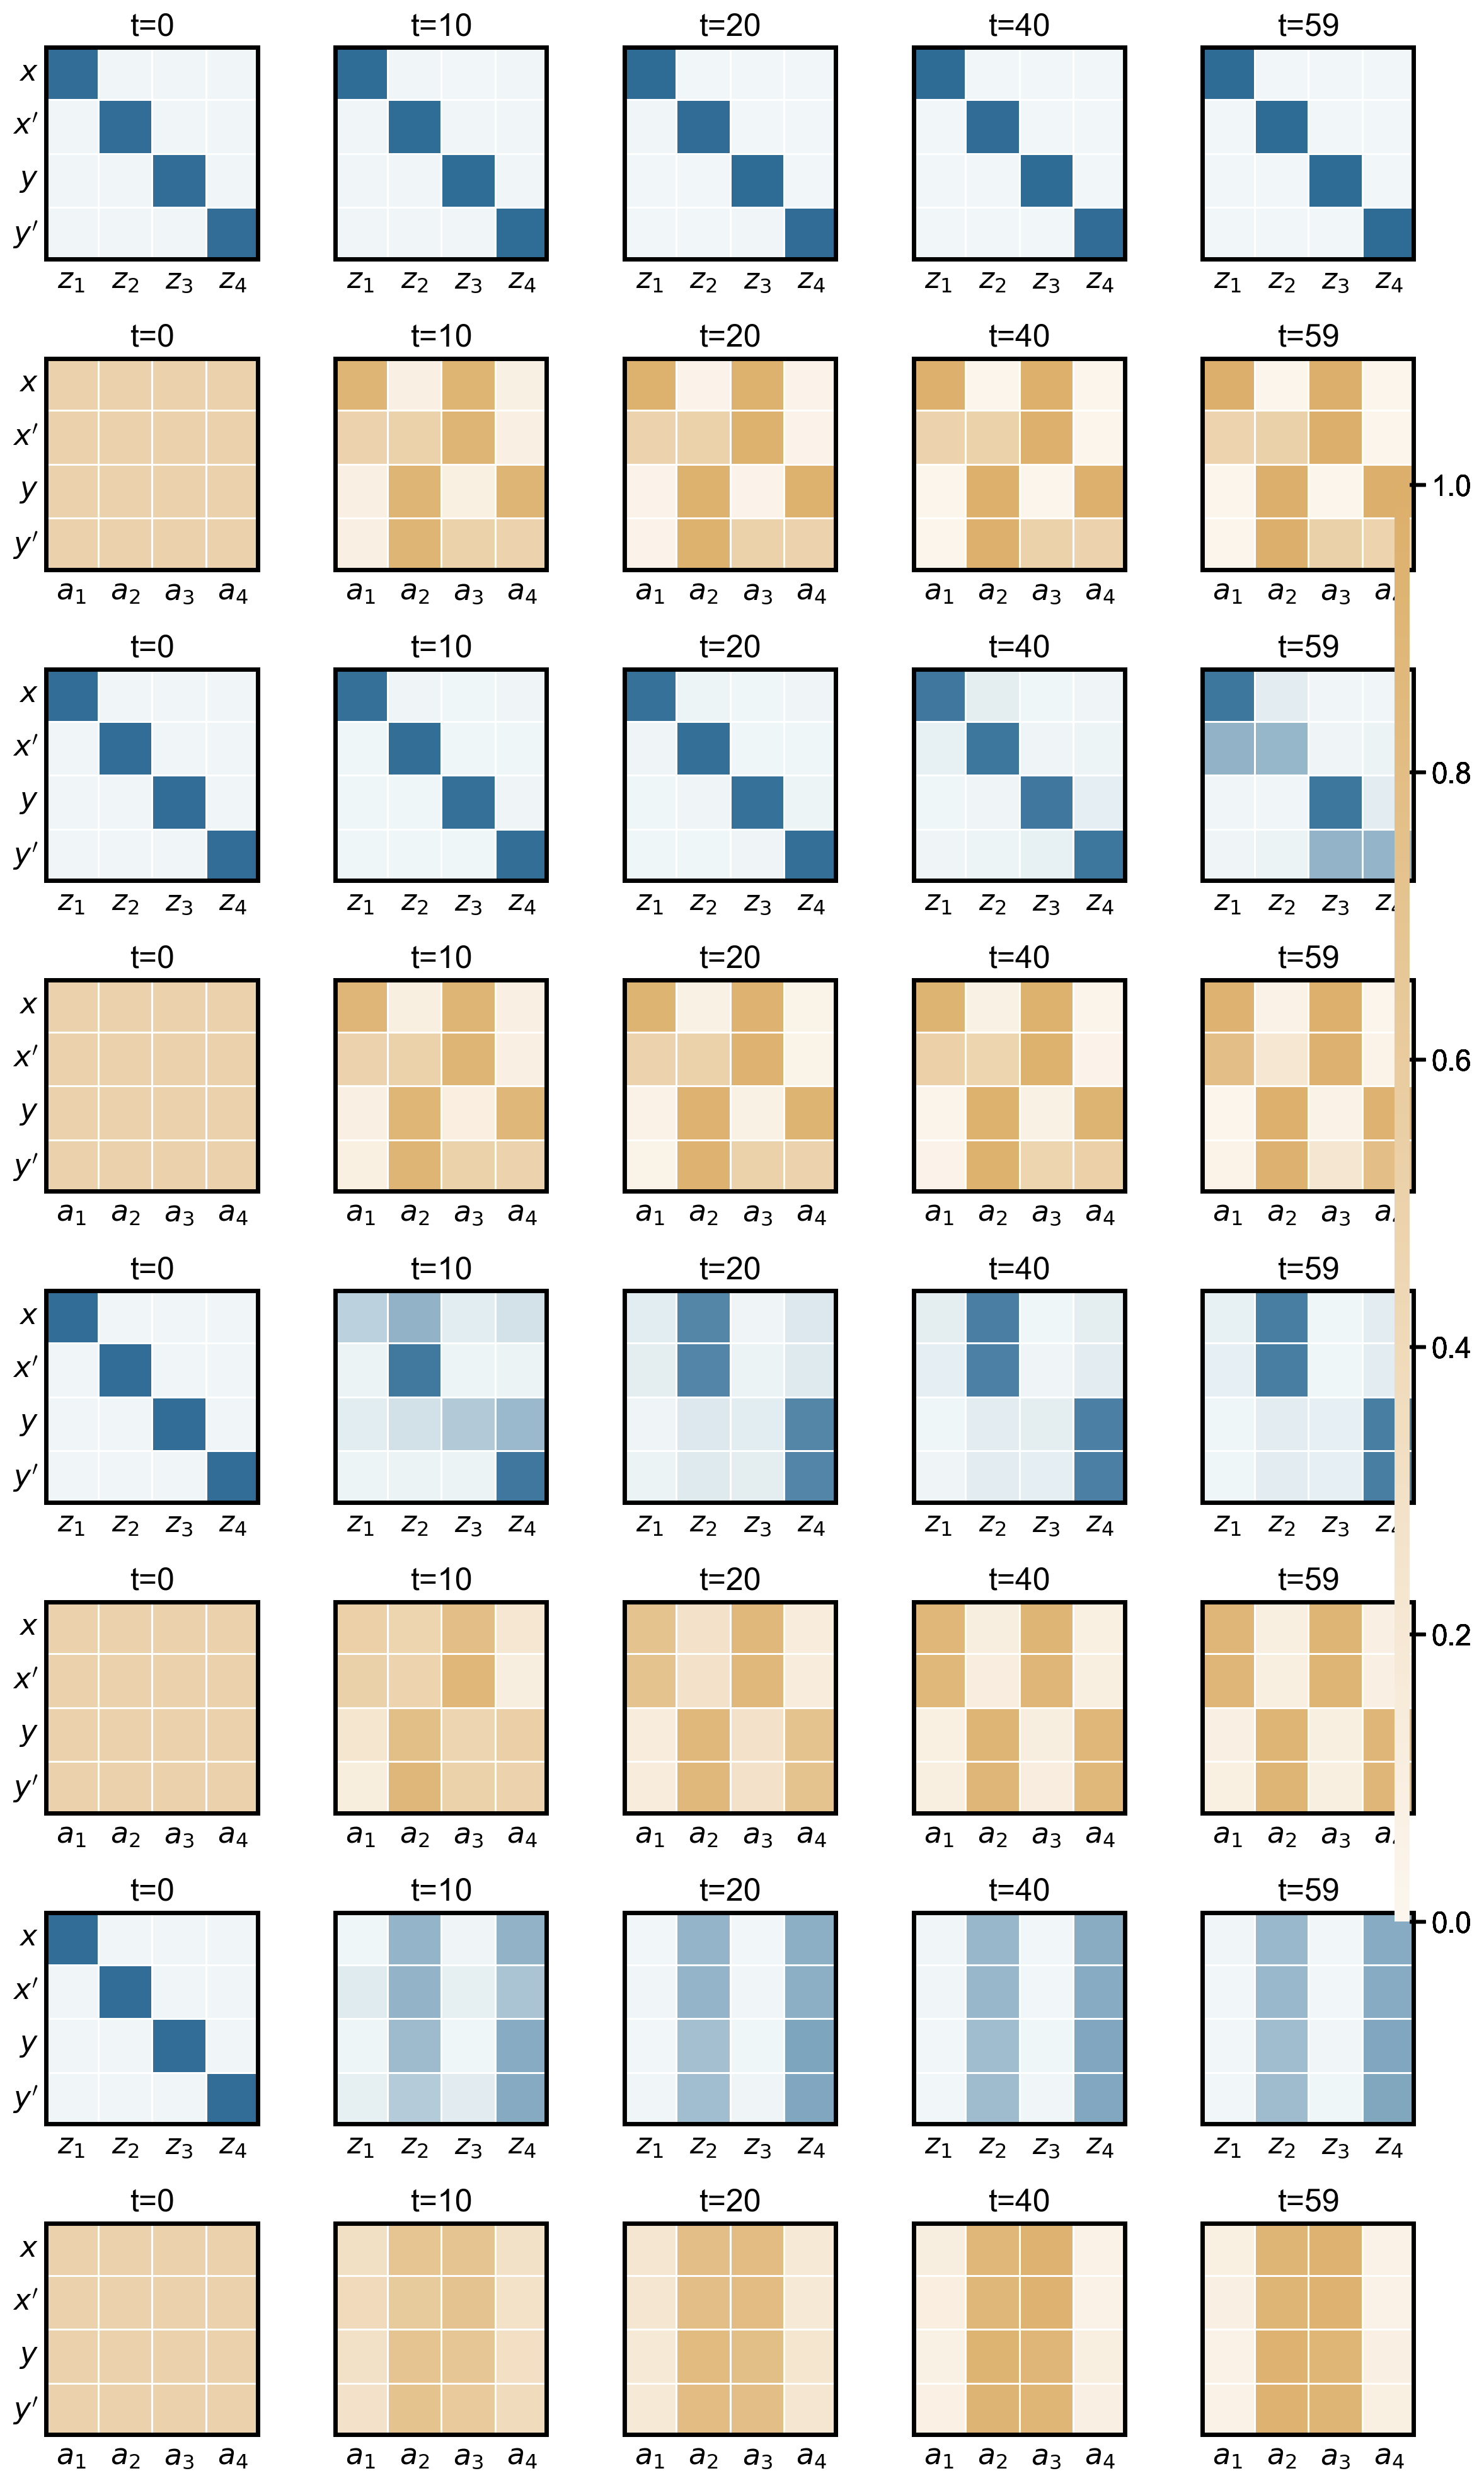

In [23]:
lmbdas = [0, .07, .2, .5]
trials = [0, 10, 20, 40, 59]
nr, nc = len(lmbdas)*2, len(trials)
fig, axs = plt.subplots(nr, nc, figsize=(nc*2.4, nr*2.5), sharey=True)
for i, lmbda in enumerate(lmbdas):
    # load data 
    fname = f'../simulations/exp1/ecPG_sim/simsubj-cont_voi-'
    fname += f'alpha_psi=40-alpha_rho=8-lmbda={lmbda}.pkl'
    with open(fname, 'rb')as handle:voi = pickle.load(handle)
    fname = f'../simulations/exp1/ecPG_sim/simsubj-cont_data-'
    fname += f'alpha_psi=40-alpha_rho=8-lmbda={lmbda}.csv'
    sim_data = pd.read_csv(fname)
    sim_Insight(axs[2*i, :], voi, sim_data, tar='enc', trials=trials)
    sim_Insight(axs[2*i+1, :], voi, sim_data, tar='pol', trials=trials)
    #axs[2*i, 2].set_title(f'λ = {lmbda}')
fig.tight_layout()
plt.savefig(f'../figures/extend_data/FigS2_state_abstract_all_lmbda.pdf', dpi=dpi)

## Model fitting in Experiment 1 

In [3]:
data_set = 'exp1'
block_types = ['cons', 'cont', 'conf']
models = ['ecPG', 'rmPG', 'caPG', 
          'LC', 'MA', 
          'l1PG', 'l2PG', 'dcPG']
method = 'map'

ECPG: 0.847112 vs. L2PG: 0.152878


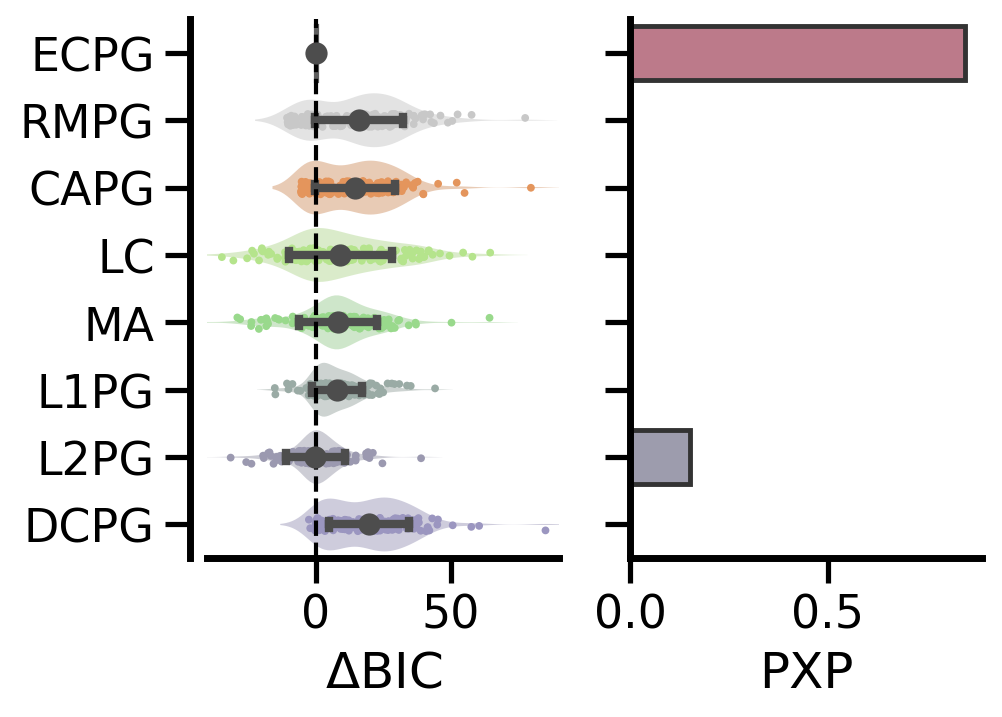

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3.5), sharey=True)
model_compare_violin(axs, data_set, models)
axs[0].set_xlim([-40, 90])
_, pxp = get_llh_score(data_set, models, method='map', 
                         if_bms=True, use_bic=True)
ecpg_pxp = pxp.query('model=="ecPG"')['pxp'].values[0]
l2pg_pxp = pxp.query('model=="l2PG"')['pxp'].values[0]
print(f'ECPG: {ecpg_pxp} vs. L2PG: {l2pg_pxp}')
plt.savefig(f'../figures/extend_data/FigS3_comparison_exp1.pdf', dpi=dpi)

## Learning and generalization

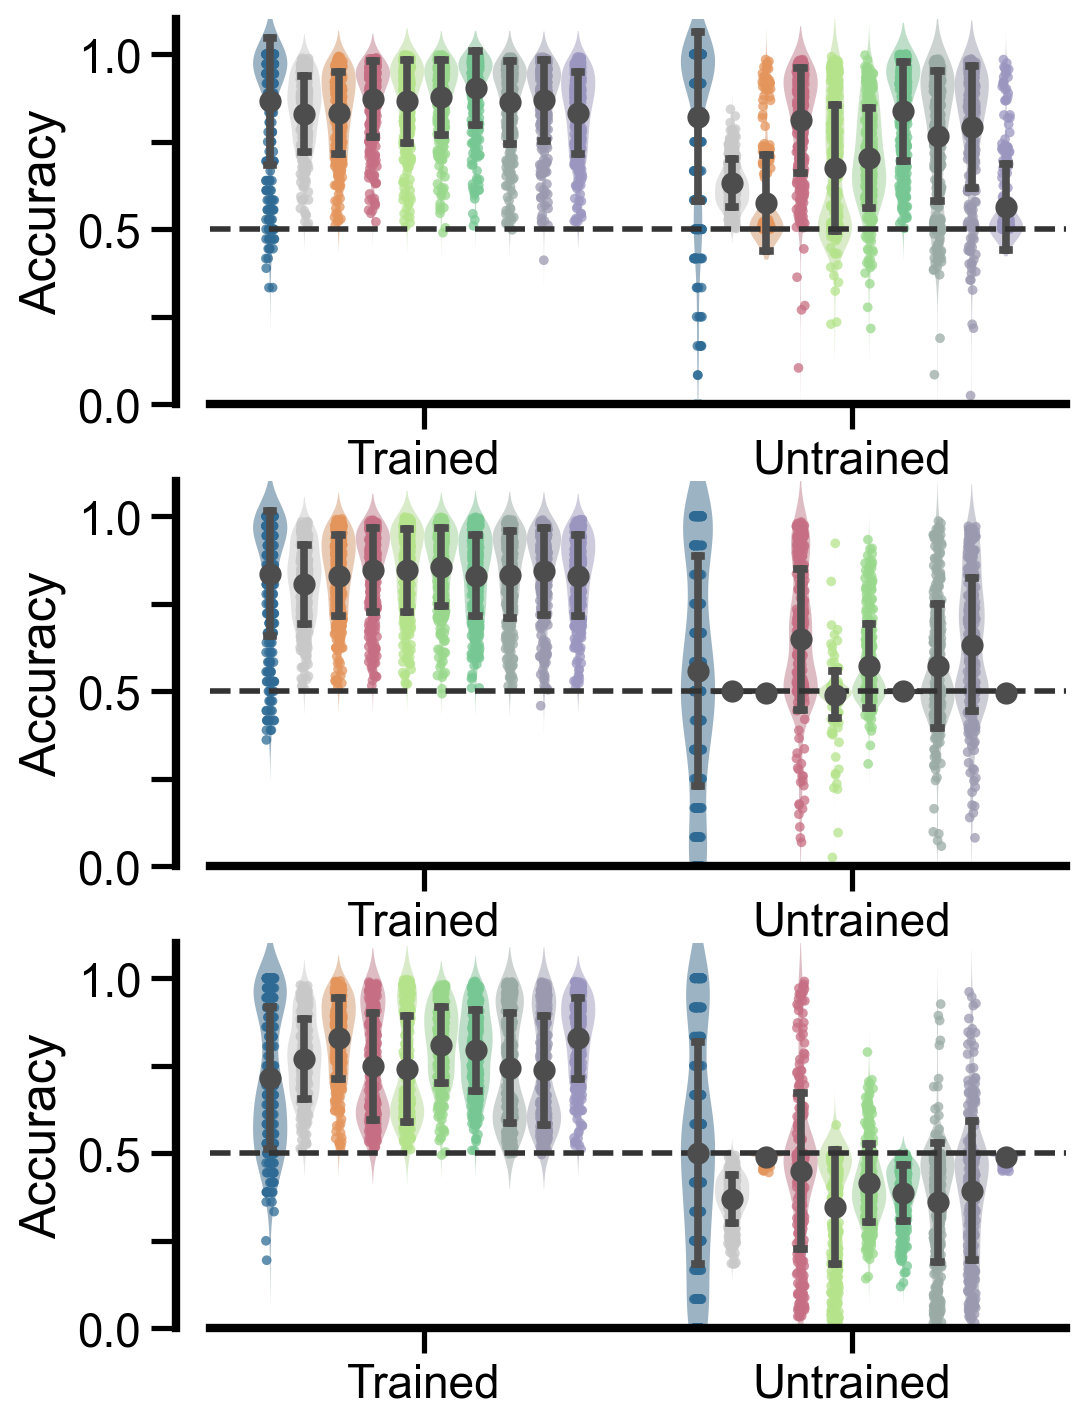

In [18]:
models = ['rmPG_fea', 'caPG_fea', 'ecPG_fea', 
          'LC', 'MA', 'ACL', 
          'l1PG_fea', 'l2PG_fea', 'dcPG_fea']
fig, axs = plt.subplots(3, 1, figsize=(8.5, 8.5), sharey=True)
generalize_exp2(axs, 'exp2', ['human']+models, method='map')
for ax in axs: 
    ax.set_box_aspect(.45)
    ax.set_ylim([0, 1.1])
plt.savefig(f'../figures/extend_data/FigS4_generalization.pdf', dpi=dpi)

## Response to the probe stimuli 

In [26]:
def viz_probe(axs, data_set, models, method, goodPoor=None):
    n = len(models) 
    for i, m in enumerate(models):
        if m == 'human':
            fname = f'{pth}/../data/{data_set}-human.csv'
            s = 1
        else:
            fname = f'{pth}/../simulations/{data_set}/{m}/sim-{method}.csv'
            s = 10
        data = pd.read_csv(fname, index_col=0)
        sel_data = data.query('group=="probe"').reset_index()
        for j, cond in enumerate(['cons', 'cont', 'conf']):
            ax = axs[i, j] if n > 1 else axs[j]
            sdata = sel_data.query(f'block_type=="{cond}"').copy()
            if goodPoor is not None: sdata = sdata.query(f'goodPoor=="good"').copy()
            # yvar = 'r' if m=='human' else 'acc' 
            if m!='human': sdata['r'] = sdata['acc']
            gdata = sdata.groupby(by=['sub_id', 'a', 'block_type']).count()['r'].reset_index()
            ptable = gdata.pivot_table(values='r', index='sub_id', columns='a').fillna(0) / (6*s)
            ptable.columns = [0, 1, 2, 3]
            ptable = ptable.reset_index()
            ptable = ptable.melt(id_vars='sub_id', value_vars=[0, 1, 2, 3]
                        ).rename(columns={'variable': 'a', 'value':'prop'})
        
            sns.stripplot(x='a', y='prop', data=ptable, 
                        color=viz.Pal_type[j], #dodge=True, 
                        edgecolor='none', size=2.8,
                        jitter=True, alpha=.3,
                        legend=False, zorder=2,
                        ax=ax)
            sns.violinplot(x='a', y='prop', data=ptable,
                        legend=False, alpha=.3, inner=None,
                        density_norm='width', edgecolor=[.8]*3,
                        color=viz.Pal_type[j],
                        ax=ax)
            sns.barplot(x='a', y='prop', data=ptable,
                        width=.75, errorbar=('ci', 95), lw=2.5,
                        edgecolor=viz.Pal_type[j], 
                        facecolor=viz.Pal_type[j].tolist()+[.2],
                        err_kws={'color': [.2, .2, .2], 'linewidth': 2.5},
                        capsize=.2,
                        color='w', ax=ax)
            ax.set_box_aspect(.9)
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_ylim([0, 1.1])
            if j==1: ax.set_title(eval(m).name)
            ax.spines['left'].set_position(('axes',-0.05))
            for pos in ['bottom', 'left']: ax.spines[pos].set_linewidth(2.5)
            ax.set_xticks(range(4))
            ax.set_xticklabels([r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$'])


In [27]:
data_set = 'exp2'
models = ['rmPG_fea', 'caPG_fea', 'ecPG_fea', 
          'LC', 'MA', 'ACL', 
          'l1PG_fea', 'l2PG_fea', 'dcPG_fea']
method = 'map'

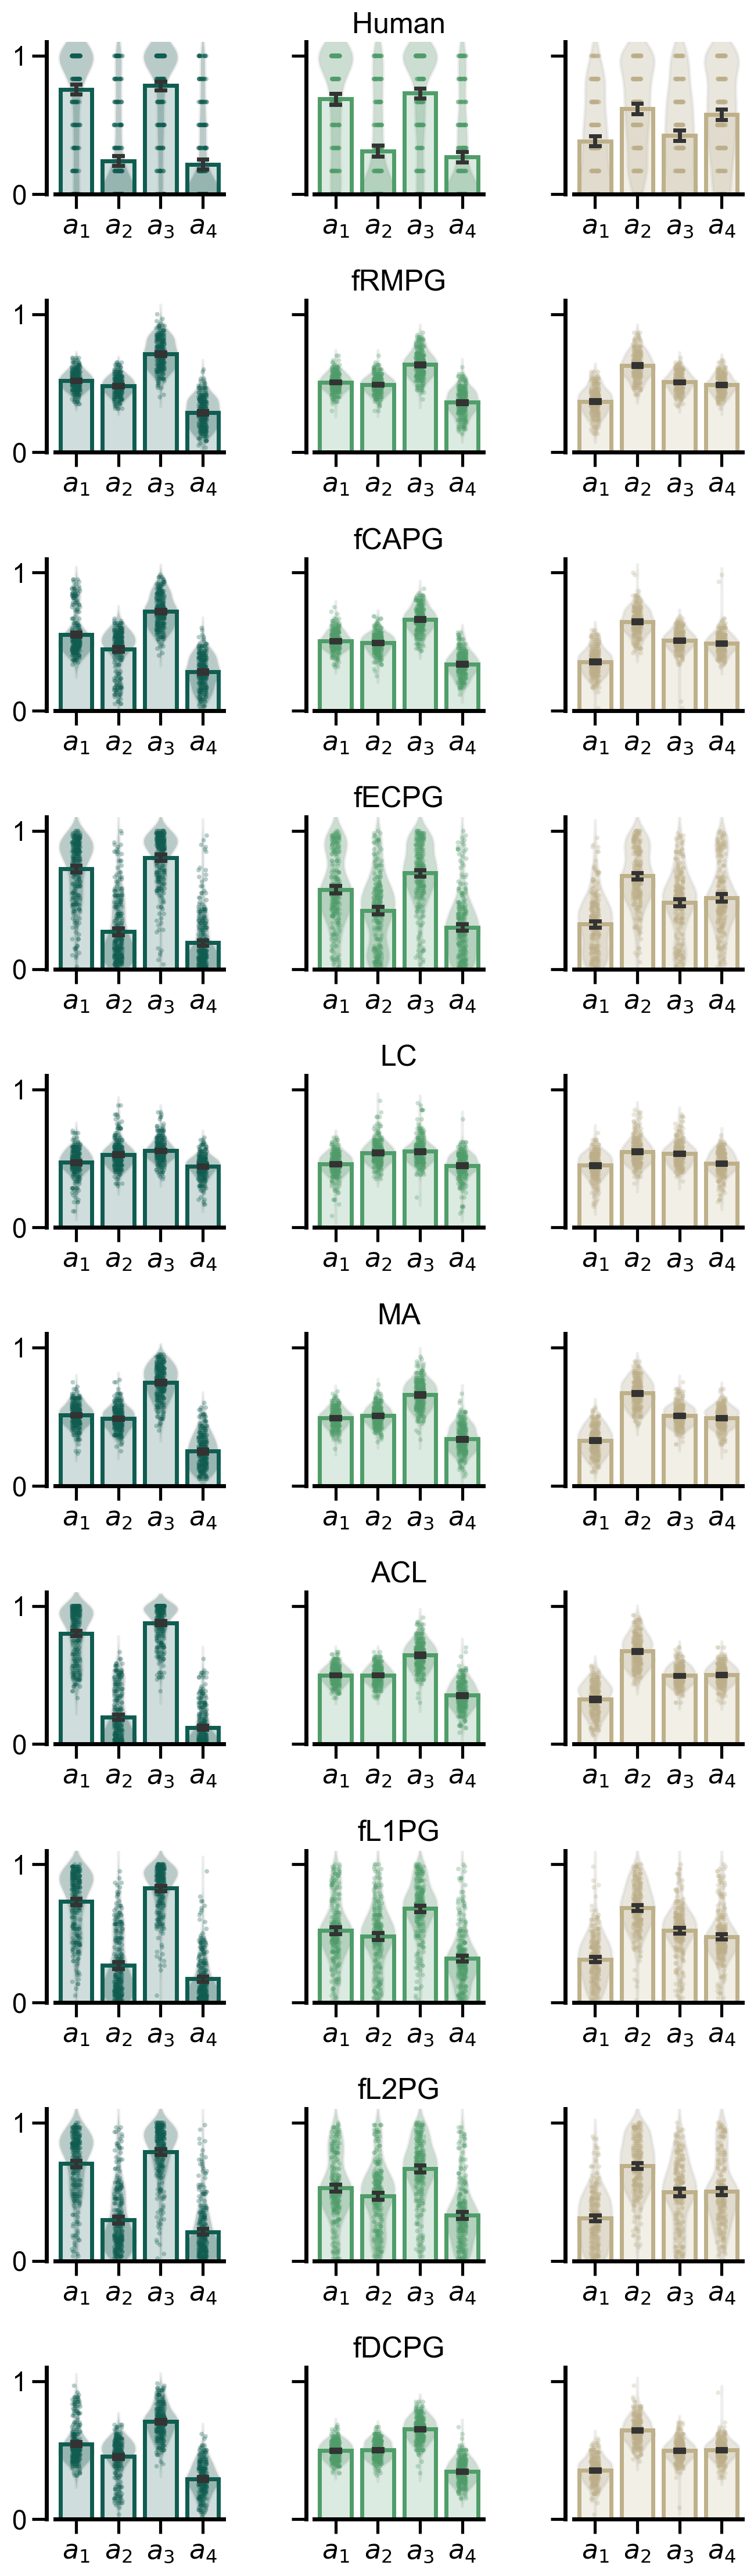

In [15]:
fig, axs = plt.subplots(len(models)+1, 3, figsize=(2.3*3.2, len(models)*2.5), sharey=True)
viz_probe(axs, 'exp2', ['human']+models, method='map')
fig.tight_layout()
plt.savefig(f'../figures/extend_data/FigS5_probe_response.pdf', dpi=dpi)

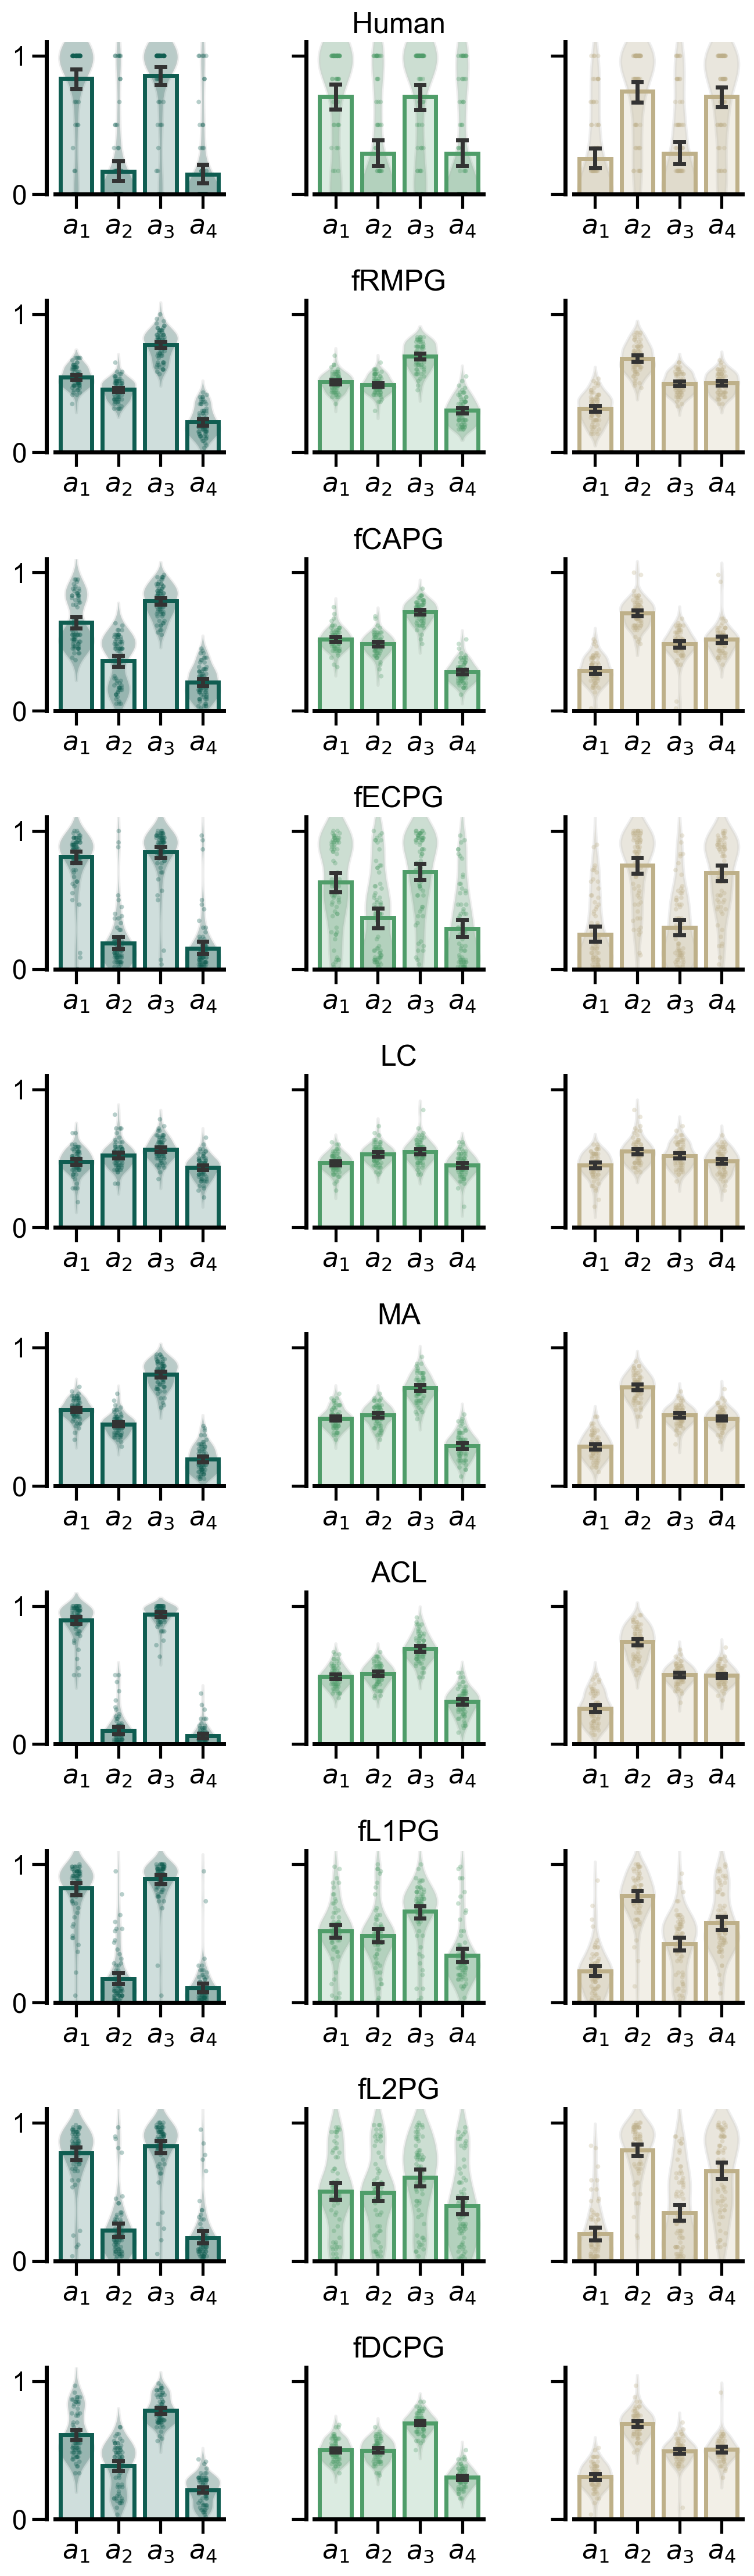

In [28]:
fig, axs = plt.subplots(len(models)+1, 3, figsize=(2.3*3.2, len(models)*2.5), sharey=True)
viz_probe(axs, 'exp2', ['human']+models, method='map', goodPoor=True)
fig.tight_layout()
plt.savefig(f'../figures/extend_data/FigS5_probe_response_good.pdf', dpi=dpi)